In [1]:
import pickle
import os
import torch
import torch_geometric
from torch_geometric.nn import GNNExplainer
import pandas as pd
import numpy as np

from datasets.datasetAtacSeqChromatin import AtacSeqChromatinDataset
from gcnmodel import GCN

Torch version: 1.8.0+cu111
Cuda available: True
Torch geometric version: 2.0.3


In [2]:
dataset = AtacSeqChromatinDataset("/gpfs/data/rsingh47/hzaki1/atacseqdataChromatin")

100%|██████████| 103480/103480 [00:04<00:00, 21451.47it/s]


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(hidden_channels=128, data=dataset, output_size=4).to(device)
model.load_state_dict(torch.load('model_weightsjun3_atacseqChromatin_data.pth'))

explainer = GNNExplainer(model, epochs=200, return_type='log_prob', feat_mask_type='individual_feature')

In [4]:
geneDict = {}
for key in dataset.cellToIndex.keys():
    geneDict[key] = {}

In [5]:
for i in range (0, len(dataset), 2):
    cellType = dataset.indexToCell[dataset[i].y[0].item()]

    feats = dataset[i].x.to(device)
    edgeIndex = dataset[i].edge_index.to(device)

    feats = torch.reshape(feats, (feats.shape[0], 2))

    feats = feats.type(torch.cuda.FloatTensor)

    node_feat_mask, edge_mask = explainer.explain_graph(feats, edgeIndex)

    indiciesOfTopExplainers = torch.topk(edge_mask, 20)[1]
    for ind in indiciesOfTopExplainers:
        nodes = edgeIndex[:, ind]
        for node in nodes:
            gene = dataset.indexToGene[int(node.item())]
            if gene in geneDict[cellType]:
                geneDict[cellType][gene] +=1
            else:
                geneDict[cellType][gene] = 1

Explain graph: 100%|██████████| 200/200 [00:01<00:00, 193.33it/s]


Explain graph: 100%|██████████| 200/200 [00:01<00:00, 193.85it/s]


Explain graph: 100%|██████████| 200/200 [00:01<00:00, 193.00it/s]


Explain graph: 100%|██████████| 200/200 [00:01<00:00, 191.89it/s]


Explain graph: 100%|██████████| 200/200 [00:01<00:00, 192.76it/s]


In [6]:
def save_obj(obj, name):
    with open('/gpfs/data/rsingh47/hzaki1/atacseqdata/obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('/gpfs/data/rsingh47/hzaki1/atacseqdata/obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [7]:
save_obj(geneDict, "interpretationAtacSeq_datasetaugmentation")

In [9]:
from datasets.datasetAtacSeq import AtacSeqDataset
dataset = AtacSeqDataset("/gpfs/data/rsingh47/hzaki1/atacseqdata")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(hidden_channels=128, data=dataset, output_size=4).to(device)
model.load_state_dict(torch.load('model_weightsjun3_atacseq_data.pth'))

explainer = GNNExplainer(model, epochs=200, return_type='log_prob', feat_mask_type='individual_feature')

geneDict = {}
for key in dataset.cellToIndex.keys():
    geneDict[key] = {}
    
for i in range (0, len(dataset), 2):
    cellType = dataset.indexToCell[dataset[i].y[0].item()]

    feats = dataset[i].x.to(device)
    edgeIndex = dataset[i].edge_index.to(device)

    feats = torch.reshape(feats, (feats.shape[0], 1))

    feats = feats.type(torch.cuda.FloatTensor)

    node_feat_mask, edge_mask = explainer.explain_graph(feats, edgeIndex)

    indiciesOfTopExplainers = torch.topk(edge_mask, 20)[1]
    for ind in indiciesOfTopExplainers:
        nodes = edgeIndex[:, ind]
        for node in nodes:
            gene = dataset.indexToGene[int(node.item())]
            if gene in geneDict[cellType]:
                geneDict[cellType][gene] +=1
            else:
                geneDict[cellType][gene] = 1

save_obj(geneDict, "interpretationWoAtacSeq_datasetaugmentation")

Explain graph: 100%|██████████| 200/200 [00:01<00:00, 194.06it/s]


Explain graph: 100%|██████████| 200/200 [00:01<00:00, 194.06it/s]


Explain graph: 100%|██████████| 200/200 [00:01<00:00, 191.87it/s]


Explain graph: 100%|██████████| 200/200 [00:01<00:00, 193.09it/s]


Explain graph: 100%|██████████| 200/200 [00:01<00:00, 193.45it/s]


In [6]:
atacseqInt = load_obj("interpretation_wAtacSeq")

In [7]:
gmInt = load_obj('interpretationGM')
bjInt = load_obj('interpretationBJ')
h1Int = load_obj('interpretationH1')

In [17]:
dataset[0].x[:,0]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [97]:
import numpy as np
matChr = np.zeros((1047,18666))

In [98]:
for count,data in enumerate(dataset):
    matChr[count] = data.x[:,0]

In [49]:
from sklearn.decomposition import PCA

In [50]:
pca = PCA(n_components=2)
XtChr = pca.fit_transform(matChr)

In [24]:
labels = np.zeros((1047))
for count,data in enumerate(dataset):
    labels[count] = data.y.item()

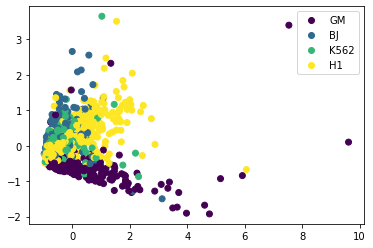

In [52]:
import matplotlib.pyplot as plt
plot = plt.scatter(XtChr[:,0], XtChr[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0], labels=list(dataset.cellToIndex.keys()))
plt.show() #chromatin directly from dataset

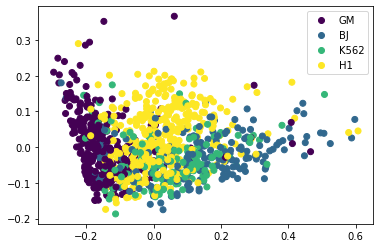

In [60]:
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
pca = PCA(n_components=2)
pipe = Pipeline([('normalizer', Normalizer()), ('pca', pca)])
XtChr = pipe.fit_transform(matChr)
plot = plt.scatter(XtChr[:,0], XtChr[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0], labels=list(dataset.cellToIndex.keys()))
plt.show() #chromatin from dataset using normalizer

In [54]:
matExp = np.zeros((1047,18666))

In [55]:
for count,data in enumerate(dataset):
    matExp[count] = data.x[:,1]

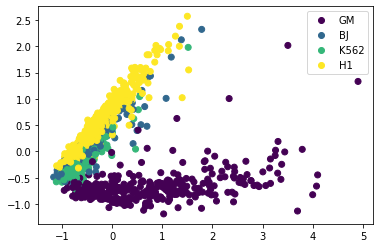

In [56]:
pca = PCA(n_components=2)
XtExp = pca.fit_transform(matExp)
plot = plt.scatter(XtExp[:,0], XtExp[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0], labels=list(dataset.cellToIndex.keys()))
plt.show() #expression from dataset

In [62]:
import os
RESOURCES_FOLDER="/gpfs/data/rsingh47/hzaki1/atacseqdataChromatin/resources"
SC_EXP_FNAME = os.path.join(RESOURCES_FOLDER, "GSE126074_CellLineMixture_SNAREseq_cDNA_counts.tsv")
exmatrix = pd.read_csv(SC_EXP_FNAME, sep='\t', header=0, index_col=0).T

In [64]:
ex = exmatrix.to_numpy()

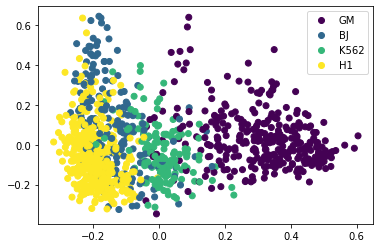

In [93]:
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
pca = PCA(n_components=2)
normaled = normalize(ex,axis=1)
Xt = pca.fit_transform(normaled)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0], labels=list(dataset.cellToIndex.keys()))
plt.show() #expression from tsv

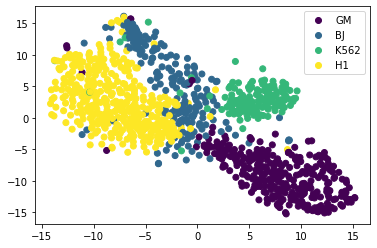

In [95]:
from sklearn.manifold import TSNE
embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(ex)
plot = plt.scatter(embedded[:,0], embedded[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0], labels=list(dataset.cellToIndex.keys()))
plt.show() #tsne expression from tsv

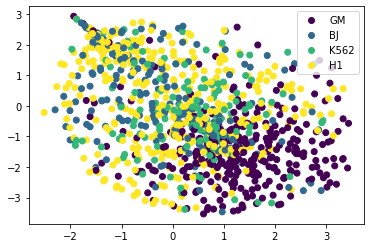

In [99]:
embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(matChr)
plot = plt.scatter(embedded[:,0], embedded[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0], labels=list(dataset.cellToIndex.keys()))
plt.show() #tsne expression from dataset

In [104]:
from tqdm import tqdm

COUNTS_FNAME = os.path.join(RESOURCES_FOLDER, "GSE126074_CellLineMixture_SNAREseq_chromatin_counts.tsv")
counts = pd.read_csv(COUNTS_FNAME, sep='\t').T
regionToGene = load_obj('regionToGene_human10')
matChrNotTransformed = np.zeros((1047,18666))
count = 0
for index, row in tqdm(counts.iterrows(), total=counts.shape[0]):
    # Get node features
    for gene in list(regionToGene.keys()):
        val = 0
        for region in regionToGene[gene]:
            val += counts[region][row.name]
        matChrNotTransformed[count][dataset.geneToIndex[gene]] = val
    count +=1

100%|██████████| 1047/1047 [08:50<00:00,  1.97it/s]


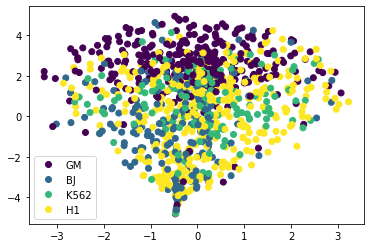

In [106]:
embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(matChrNotTransformed)
plot = plt.scatter(embedded[:,0], embedded[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0], labels=list(dataset.cellToIndex.keys()))
plt.show() #tsne from tsv

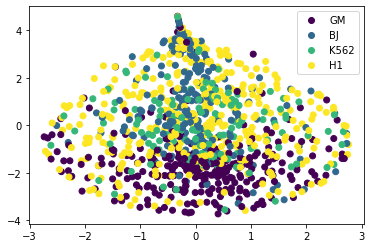

In [107]:
COUNTS_FNAME = os.path.join(RESOURCES_FOLDER, "GSE126074_CellLineMixture_SNAREseq_chromatin_counts.tsv")
counts = pd.read_csv(COUNTS_FNAME, sep='\t').T
countsArray = counts.to_numpy()
countsArray = np.where(countsArray >=1 , 1, 0)

colsToDelete = []
for col in range (countsArray.shape[1]):
    tot = np.sum(arr[:,col])
    
    if tot < 5 || tot > 105:
        colsToDelete.append(col)
    

embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(countsArray)
plot = plt.scatter(embedded[:,0], embedded[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0], labels=list(dataset.cellToIndex.keys()))
plt.show() #TSNE before removal

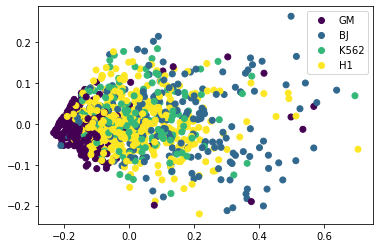

In [108]:
pca = PCA(n_components=2)
pipe = Pipeline([('normalizer', Normalizer()), ('pca', pca)])
XtChr = pipe.fit_transform(countsArray)
plot = plt.scatter(XtChr[:,0], XtChr[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0], labels=list(dataset.cellToIndex.keys()))
plt.show() #PCA from from counts without removal

In [10]:
import numpy as np

RESOURCES_FOLDER="/gpfs/data/rsingh47/hzaki1/atacseqdataChromatin/resources"
COUNTS_FNAME = os.path.join(RESOURCES_FOLDER, "GSE126074_CellLineMixture_SNAREseq_chromatin_counts.tsv")
counts = pd.read_csv(COUNTS_FNAME, sep='\t').T
countsArray = counts.to_numpy()
countsArray = np.where(countsArray >=1 , 1, 0)

In [11]:
colsToDelete = []
counter = 0
for col in range (countsArray.shape[1]):
    tot = np.sum(countsArray[:,col])
    if tot < 5 or tot > 105:
        colsToDelete.append(col)
        counter +=1

In [17]:
print(counts.shape)
print(counter)

(1047, 136771)
78664


In [20]:
countsDel = np.delete(countsArray, colsToDelete, 1)

In [21]:
countsDel.shape

(1047, 58107)

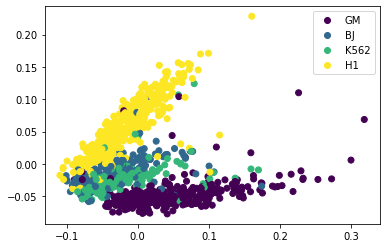

In [25]:
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pipe = Pipeline([('normalizer', Normalizer()), ('pca', pca)])
XtChr = pipe.fit_transform(countsDel)
plot = plt.scatter(XtChr[:,0], XtChr[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0], labels=list(dataset.cellToIndex.keys()))
plt.show() #PCA after removal

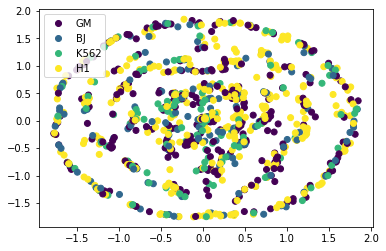

In [60]:
from sklearn.manifold import TSNE

embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(countsDel)
plot = plt.scatter(embedded[:,0], embedded[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0], labels=list(dataset.cellToIndex.keys()))
plt.show() #TSNE after removal

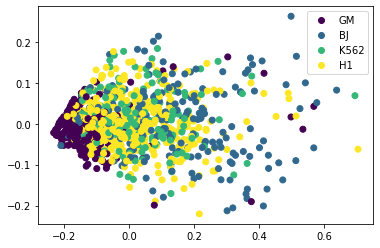

In [63]:
RESOURCES_FOLDER="/gpfs/data/rsingh47/hzaki1/atacseqdataChromatin/resources"
COUNTS_FNAME = os.path.join(RESOURCES_FOLDER, "GSE126074_CellLineMixture_SNAREseq_chromatin_counts.tsv")
counts = pd.read_csv(COUNTS_FNAME, sep='\t').T
countsArray = counts.to_numpy()

pca = PCA(n_components=2)
pipe = Pipeline([('normalizer', Normalizer()), ('pca', pca)])
XtChr = pipe.fit_transform(countsArray)
plot = plt.scatter(XtChr[:,0], XtChr[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0], labels=list(dataset.cellToIndex.keys()))
plt.show() #counts before removal

In [64]:
def save_obj(obj, name):
    with open('obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [65]:
mouseBrainInt = load_obj('InterpretationDictNov22_mouseBrain')

In [80]:
{k: v for k, v in sorted(mouseBrainInt['interneurons'].items(), key=lambda item: item[1], reverse=True)}

{'Pkm': 118,
 'Tceal5': 117,
 'Ckmt1': 116,
 'Rab14': 92,
 'Rab2a': 91,
 'Ywhae': 89,
 'Rufy3': 87,
 'Celf4': 86,
 'Ywhaz': 85,
 'Got1': 84,
 'Zmat2': 81,
 'Pura': 81,
 'Nap1l1': 80,
 'Cbx3': 80,
 'Nme1': 72,
 'Mapk1': 71,
 'Tppp': 71,
 'Prdx5': 69,
 'Npdc1': 67,
 'Ube2k': 63,
 'Ctnnb1': 60,
 'Rpl6': 59,
 'Taf9': 59,
 'Psmc2': 58,
 'Cxx1c': 54,
 'Sod1': 50,
 'Ran': 47,
 'Celf5': 47,
 'Rpl35': 47,
 'Hp1bp3': 44,
 'Tpi1': 42,
 'Prnp': 41,
 'Tcf4': 40,
 'Mbnl2': 39,
 'H2afz': 39,
 'Uqcrb': 38,
 'Psma6': 36,
 'Zfp706': 36,
 'Suclg1': 36,
 'Cycs': 36,
 'Zcchc17': 33,
 'Cfl2': 32,
 'Stub1': 32,
 'Zeb2': 32,
 'Rbfox2': 31,
 'Apex1': 31,
 'Peg3': 31,
 'Foxg1': 30,
 'Bclaf1': 30,
 'Bcl11a': 30,
 'Id2': 30,
 'Srp9': 28,
 'Canx': 28,
 'Nfe2l1': 27,
 'Hmgb1': 27,
 'Hnrnpc': 27,
 'Gtf2i': 26,
 'Churc1': 25,
 'Pqbp1': 24,
 'Psmd12': 23,
 'Agap2': 23,
 'Gtf2a2': 22,
 'Atf5': 22,
 'Maf': 22,
 'Akr1a1': 21,
 'Klf13': 20,
 'Ncald': 20,
 'Hspa5': 20,
 'Tsn': 20,
 'P4hb': 19,
 'Pbx1': 19,
 'Msi2': 19,
 'K

In [69]:
RESOURCES_FOLDER="/gpfs/data/rsingh47/hzaki1/data/resources"
DATABASE_FOLDER = "/gpfs/data/rsingh47/hzaki1/data/databases"
METADATA_FNAME = os.path.join(RESOURCES_FOLDER, 'metadata.txt')

metadata = pd.read_csv(METADATA_FNAME,  sep='\t', index_col=1, nrows=9).drop(columns=['Unnamed: 0']).T.reset_index()

In [71]:
metadata['level1class'].value_counts()

pyramidal CA1           939
oligodendrocytes        820
pyramidal SS            399
interneurons            290
endothelial-mural       235
astrocytes_ependymal    224
microglia                98
Name: level1class, dtype: int64

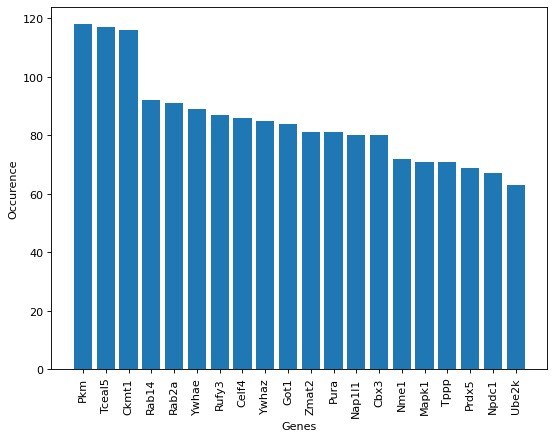

In [88]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation = 90)

data = {k: v for k, v in sorted(mouseBrainInt['interneurons'].items(), key=lambda item: item[1], reverse=True)}
names = list(data.keys())[0:20]
values = list(data.values())[0:20]

plt.xlabel('Genes')
plt.ylabel('Occurence')
plt.bar(range(20), values, tick_label=names)
plt.show()